# 한국은행 의사록 어조 분석

이제 극성사전이 완성되었으므로, 이를 이용해 한국은행 의사록의 어조(tone)을 측정하도록 한다. 

우선 각 일자의 한국은행 의사록을 `sentences`로 분리한 뒤, 각 `sentences`를 다시 `ngrams`로 분리한다. 

문장별로 추출한 `ngrams`를 바탕으로 각 문장의 `tone_sentence`를 계산한다. 

문장별 `tone_sentence`가 계산됐으면, 문장을 다시 합쳐 문서(의사록)의 `tone_doc`을 구한다. 

한 날짜에는 한 문서가 있고, 따라서 한 `tone_doc`이 있으므로, 이제 이 데이터를 바탕으로 한국은행 기준금리 데이터와의 상관관계와 그래프를 확인한다. 

In [115]:
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import multiprocessing as mp

import preprocessing_mp_worker as worker

## 의사록 데이터를 불러온다. 

김현진T 코드를 기반으로 minutes_ngram df를 만들 때 문장을 @@@로 split하였다. 따라서 의사록 섹션 2,3을 문장으로 나눌 때 @@@로 split해주면 충분하다. 

In [150]:
minutes_df = pd.read_pickle('./data_files/BOK_minutes/pkl/minutes_ngram.pkl')
# minutes_df = minutes_df[['date', 'minutes']]
minutes_df.loc[:, 'sections'] = minutes_df['Foreign Currency'] + minutes_df['Financial Markets']
# minutes_df = minutes_df[['date', 'sections']]
minutes_df.head()

,date,minutes,Foreign Currency,Financial Markets,ngrams,sections
0,2005-06-09,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...,일부 위원은 M1이 실물경제와 어느 정도의 시차를 두고 밀접한 연관성을 지니는지...,"[경제/NNG, 경제/NNG, 비해/VV, 특별/NNG, 요인/NNG, 불구/NNG...",일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...
1,2005-06-23,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,,,[],
2,2005-07-07,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,일부 위원은 6월 들어 국제유가가 크게 오르고 원화와 엔화간 동조화 현상이 뚜렷...,일부 위원은 단기적으로 대출이 급격히 증가 한 후에는 반드시 조정이 이어지고 민간...,"[국제/NNG, 유가/NNG, 오르/VV, 원화/NNG, 화간/NNG, 동조/NNG...",일부 위원은 6월 들어 국제유가가 크게 오르고 원화와 엔화간 동조화 현상이 뚜렷...
3,2005-08-11,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,일부 위원은 위안화 절상 이후 아시아 통화중 우리나라 원화의 절상폭이 가장 컸다...,일부 위원은 최근 장기시장금리 상승에도 불 구하고 기업 자금조달은 오히려 확대되고...,"[위안/NNG, 절상/NNG, 원화/NNG, 절상/NNG, 가장/MAG, 추가/NN...",일부 위원은 위안화 절상 이후 아시아 통화중 우리나라 원화의 절상폭이 가장 컸다...
4,2005-09-08,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,일부 위원은 최근 인도네시아 금융불안 사태가 발생한 가운데 국제 환투기세력이 인...,일부 위원은 시장이 제대로 작동한다면 비우 - 5 - 량등급의 회사채 가산금...,"[금융/NNG, 불안사태/NNG, 발생/NNG, 가운데/NNG, 국제/NNG, 환투...",일부 위원은 최근 인도네시아 금융불안 사태가 발생한 가운데 국제 환투기세력이 인...


In [151]:
minutes_df.date = pd.to_datetime(minutes_df.date)
minutes_df[(minutes_df.date > pd.to_datetime('2008-01-01')) & (minutes_df.date < pd.to_datetime('2011-12-31'))]

,date,minutes,Foreign Currency,Financial Markets,ngrams,sections
53,2008-01-04,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,,,[],
54,2008-01-10,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,일부 위원은 최근 크게 확대된 해외증 권투자에 대해 일각에서는 투자자금에 대한 환...,일부 위원은 은행들이 주식시장으로 자금이 이동하는 상황에서 대출을 축소하기보다는...,"[확대/NNG, 외증/NNG, 투자/NNG, 대해/VV, 일각/NNG, 투자자금/N...",일부 위원은 최근 크게 확대된 해외증 권투자에 대해 일각에서는 투자자금에 대한 환...
55,2008-01-24,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,,,[],
56,2008-02-13,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,,,[],
57,2008-03-07,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,,,[],
...,...,...,...,...,...,...
139,2011-11-24,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,,,[],
140,2011-12-08,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,,,[],
141,2011-12-16,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,,,[],
142,2011-12-22,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,,,[],


## 의사록 섹션 2, 3(`sections`)를 문장(`sentences`)들로 분리한다. 

In [117]:
def split_by_at_sign(text):
    return text.split('@@@')

In [118]:
%%time

# minutes_df.loc[:, 'sentences'] = minutes_df.minutes.map(lambda x: worker.tidy_sentences(x)[0])
minutes_df.loc[:, 'sentences'] = minutes_df.sections.map(split_by_at_sign)

Wall time: 14.6 ms


In [119]:
minutes_df = minutes_df.explode('sentences')
minutes_df.head()

,date,sections,sentences
0,2005-06-09,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...
0,2005-06-09,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...,- 6 - 동 위원은 환율이 중장기적으로 각국의 기초경제여건(fundamen...
0,2005-06-09,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...,다른 일부 위원은 최근 유로지역의 경제성장 실적이 예상보다 저조한 가운 데 일각에...
0,2005-06-09,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...,동 위원은 국내 금리가 현 수준에서 유지되고 미국 금리가 상승하는 가운 데 달러화...
0,2005-06-09,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...,다른 일부 위원은 최근 가계대출의 월평균 증가액이 2003년과 지난해 실적 을 크...


In [120]:
minutes_df.dropna(inplace=True) # sentences가 np.nan이라서 float으로 들어가 오류나는 경우 존재한다. 
minutes_df.date = pd.to_datetime(minutes_df.date)
minutes_df.reset_index(drop=True, inplace=True)

In [121]:
len(minutes_df)

11502

In [122]:
minutes_df.describe()

,date,sections,sentences
count,11502,11502,11502
unique,301,117,11051
top,2012-04-13 00:00:00,일부 위원은 최근 일부 기업의 해외 현지법인이 해외채권을 외평채 보다도 낮은 금리...,
freq,324,324,185
first,2005-06-09 00:00:00,NaN,NaN
last,2020-01-17 00:00:00,NaN,NaN


In [123]:
minutes_df.head()

,date,sections,sentences
0,2005-06-09,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...
1,2005-06-09,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...,- 6 - 동 위원은 환율이 중장기적으로 각국의 기초경제여건(fundamen...
2,2005-06-09,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...,다른 일부 위원은 최근 유로지역의 경제성장 실적이 예상보다 저조한 가운 데 일각에...
3,2005-06-09,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...,동 위원은 국내 금리가 현 수준에서 유지되고 미국 금리가 상승하는 가운 데 달러화...
4,2005-06-09,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...,다른 일부 위원은 최근 가계대출의 월평균 증가액이 2003년과 지난해 실적 을 크...


## 각 문장을 `ngrams`로 분리한다. 

In [13]:
%%time 
# Wall time: 42min 39s

with mp.Pool(processes=6) as p:
    minutes_sentences_ngrams = p.map(worker.text2ngram, minutes_df.sentences)

Wall time: 10min 46s


In [124]:
len(minutes_sentences_ngrams)

11502

## Polarity Dictionary를 불러온다. 

그리고 hawkish_dictionary와 dovish_dictionary로 나눈다. 

In [125]:
polarity_dictionary = pd.read_pickle('./data_files/results/polarity_dictionary_1.3threshold.pkl')
polarity_dictionary.head()

,hawkish,dovish,total,prob_feature_given_hawkish,prob_feature_given_dovish,polarity_score
이변/NNG,9,7,16,0.000008,0.000005,1.556266
지신/NNG,12,8,20,0.000010,0.000006,1.815644
그렉시트/NNG,17,34,51,0.000014,0.000024,0.605215
실험/NNG,19,9,28,0.000016,0.000006,2.555350
자산배분전략/NNG,10,102,112,0.000008,0.000071,0.118670


In [29]:
intensity_threshold = 1.3

hawkish_dictionary = polarity_dictionary[polarity_dictionary.polarity_score >= intensity_threshold]
hawkish_dictionary = hawkish_dictionary.index

dovish_dictionary = polarity_dictionary[polarity_dictionary.polarity_score <= 1/intensity_threshold]
dovish_dictionary = dovish_dictionary.index

In [30]:
print("hawkish dictionary 크기: ", len(hawkish_dictionary))
print("dovish dictionary 크기: ", len(dovish_dictionary))

hawkish dictionary 크기:  1743
dovish dictionary 크기:  1990


뉴스 ngram 추출을 하지 않아 사전크기가 너무 작으므로, 김현진T에게 받은 뉴스데이터의 ngram까지 추가된 hawkish/dovish dictionary를 받아 결과를 확인해보겠다. 

In [126]:
alter_hawkish_dictionary = pd.read_csv('./data_files/results/close_hawkish_dic.csv')
alter_hawkish_dictionary.set_index('Unnamed: 0', inplace=True)
alter_hawkish_dictionary = alter_hawkish_dictionary.index
alter_hawkish_dictionary

Index(['인상/NNG', '종합/NNG', '배포/NNG', '전재/NNG', '기사/NNG', '뉴스/NNG', '무단/NNG',
       '긴축/NNG', '금지/NNG', '이용/NNG',
       ...
       '예상/NNG;분위기/NNG;강하/VA', '경기순환/NNG;회복/NNG', '꼬인다/VV',
       '강력/NNG;경제/NNG;회복/NNG', '산업활동/NNG;둔화/NNG',
       'ecb/NNG;국채/NNG;매입/NNG;확대/NNG', '가격/NNG;하락/NNG;오르/VV',
       '인상/NNG;불확실성/NNG;해소/NNG', '심리/NNG;위축/NNG;하락/NNG', '면세품/NNG'],
      dtype='object', name='Unnamed: 0', length=11863)

In [127]:
alter_dovish_dictionary = pd.read_csv('./data_files/results/close_dovish_dic.csv')
alter_dovish_dictionary.set_index('Unnamed: 0', inplace=True)
alter_dovish_dictionary = alter_dovish_dictionary.index
alter_dovish_dictionary

Index(['인하/NNG', '양적완화/NNG', '대책/NNG', '금융위기/NNG', '부양/NNG', '부양책/NNG',
       '저작권자/NNG', '실물/NNG', '마이너스/NNG', '금리/NNG;인하/NNG',
       ...
       '경기/NNG;둔화/NNG;피하/VV', '경기민감물가/NNG', '까맣/VA',
       '범위/NNG국채/NNG;수익률/NNG;상승/NNG', '림프종/NNG', '인플레이션/NNG;지표/NNG;악화/NNG',
       'gdp/NNG;악화/NNG', '금리/NNG;인하/NNG;무산/NNG', '전망/NNG;상향/NNG;전망/NNG;하향/NNG',
       '국채입찰/NNG;견조/NNG'],
      dtype='object', name='Unnamed: 0', length=13171)

In [128]:
'인상/NNG' in alter_hawkish_dictionary

True

## 각 문장의 tone을 구한다. 

In [129]:
def sentence_tone(sentence_ngram_list):
    hawkish_count = 0
    dovish_count = 0
    
    for ngram in sentence_ngram_list:
        if ngram in alter_hawkish_dictionary:
            hawkish_count += 1
        elif ngram in alter_dovish_dictionary:
            dovish_count += 1
        else:
            continue
    
    if (hawkish_count + dovish_count) == 0:
        return np.nan
    
    sentence_tone = (hawkish_count - dovish_count) / (hawkish_count + dovish_count)
    
    return sentence_tone

In [130]:
sentence_tone_list = [sentence_tone(ngram_list) for ngram_list in minutes_sentences_ngrams]
len(sentence_tone_list)

11502

In [137]:
sentence_tone_df = pd.DataFrame(sentence_tone_list, columns=['sentence_tone'])
minutes_df_tone = pd.concat([minutes_df, sentence_tone_df], axis=1)

In [141]:
# minutes_df_tone.dropna(inplace=True) # If drop, unique dates go from 301 to 116
minutes_df_tone

,date,sections,sentences,sentence_tone
0,2005-06-09,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...,1.000000
1,2005-06-09,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...,- 6 - 동 위원은 환율이 중장기적으로 각국의 기초경제여건(fundamen...,-0.333333
2,2005-06-09,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...,다른 일부 위원은 최근 유로지역의 경제성장 실적이 예상보다 저조한 가운 데 일각에...,0.200000
3,2005-06-09,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...,동 위원은 국내 금리가 현 수준에서 유지되고 미국 금리가 상승하는 가운 데 달러화...,0.000000
4,2005-06-09,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...,다른 일부 위원은 최근 가계대출의 월평균 증가액이 2003년과 지난해 실적 을 크...,0.000000
...,...,...,...,...
11497,2020-01-17,일부 위원은 최근 글로벌 펀드자금의 유출입 동향을 살펴보면 유럽지역 MMF 로 상...,또한 동 위원은 최근 시중 유동성이 확대되는 상황에서 도소매업과 숙박음식 점업의 ...,-1.000000
11498,2020-01-17,일부 위원은 최근 글로벌 펀드자금의 유출입 동향을 살펴보면 유럽지역 MMF 로 상...,"이 있다는 관련부서의 분석과 관련하여, 지난해 고용지표에는 각종 정책적 요인 에 ...",NaN
11499,2020-01-17,일부 위원은 최근 글로벌 펀드자금의 유출입 동향을 살펴보면 유럽지역 MMF 로 상...,또한 도소매업 등의 업황 개선 정도를 정확히 가늠하기 위해서는 법인기업 외에 영세...,-1.000000
11500,2020-01-17,일부 위원은 최근 글로벌 펀드자금의 유출입 동향을 살펴보면 유럽지역 MMF 로 상...,이에 관련부서에서는 위원이 언급한 대로 지난해 두 업종의 취업자수 개선에 기저효과...,0.000000


In [144]:
minutes_df_tone.date.describe()

count                   11502
unique                    301
top       2012-04-13 00:00:00
freq                      324
first     2005-06-09 00:00:00
last      2020-01-17 00:00:00
Name: date, dtype: object

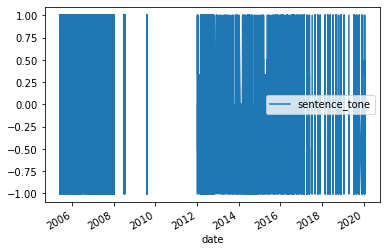

In [143]:
minutes_df_tone[['date', 'sentence_tone']].plot(x='date', y='sentence_tone')

In [22]:
minutes_df_tone.to_pickle('./data_files/results/alter_minutes_df_sentence_tone.pkl')

## 문서의 tone을 구한다. 

`.groupby('date')`를 했다. 한 날짜에 의사록이 하나 올라온다 가정. 

In [23]:
def doc_tone(sentence_tone_series):
    hawkish_count = 0
    dovish_count = 0
    
    hawkish_count = sentence_tone_series[sentence_tone_series > 0].count()
    dovish_count = sentence_tone_series[sentence_tone_series < 0].count()
    
    if (hawkish_count + dovish_count) == 0:
        return np.nan
    
    doc_tone = (hawkish_count - dovish_count) / (hawkish_count + dovish_count)
    
    return doc_tone

In [66]:
minutes_df_tone_by_date = minutes_df_tone.groupby('date')['sentence_tone'].apply(doc_tone)
minutes_df_tone_by_date = pd.DataFrame({'doc_tone': minutes_df_tone_by_date.values}, index=minutes_df_tone_by_date.index)
minutes_df_tone_by_date.dropna(inplace=True)
minutes_df_tone_by_date.tail()

,doc_tone
date,
2019-07-18,-0.473684
2019-08-30,-0.666667
2019-10-16,-0.400000
2019-11-29,-0.696970
2020-01-17,-0.520000


In [67]:
len(minutes_df_tone_by_date)

116

In [64]:
minutes_df_tone_by_date = minutes_df_tone_by_date[(minutes_df_tone_by_date.doc_tone != 1) & (minutes_df_tone_by_date.doc_tone != -1)]
len(minutes_df_tone_by_date)

115

In [68]:
minutes_df_tone_by_date.to_pickle('./data_files/results/alter_minutes_df_document_tone.pkl')

## 한국은행 기준금리 데이터를 불러와 합친다. 

In [69]:
minutes_df_tone_by_date = pd.read_pickle('./data_files/results/alter_minutes_df_document_tone.pkl')
minutes_df_tone_by_date.head()

,doc_tone
date,
2005-06-09,0.340206
2005-07-07,0.259259
2005-08-11,0.440000
2005-09-08,0.287129
2005-10-11,0.615385


In [80]:
bok_policy_rate = pd.read_csv('./data_files/BOK_2.6._base_rate.csv')
bok_policy_rate.date = pd.to_datetime(bok_policy_rate.date)
bok_policy_rate.set_index('date', inplace=True)
bok_policy_rate.head()

,base_rate
date,
2004-01-01,3.75
2004-01-02,3.75
2004-01-03,3.75
2004-01-04,3.75
2004-01-05,3.75


In [93]:
tone_and_policy_rate_df = minutes_df_tone_by_date.merge(bok_policy_rate, how='inner', left_index=True, right_index=True)
# tone_and_policy_rate_df = bok_policy_rate.merge(minutes_df_tone_by_date, how='left', left_index=True, right_index=True)
tone_and_policy_rate_df.head()

,doc_tone,base_rate
date,,
2005-06-09,0.340206,3.25
2005-07-07,0.259259,3.25
2005-08-11,0.440000,3.25
2005-09-08,0.287129,3.25
2005-10-11,0.615385,3.50


In [94]:
tone_and_policy_rate_df.to_pickle('./data_files/results/alter_tone_and_policy_rate_df.pkl')

## 상관관계 계산 및 그래프 plot

In [95]:
tone_and_policy_rate_df.corr(method='pearson')

,doc_tone,base_rate
doc_tone,1.0000,0.7738
base_rate,0.7738,1.0000


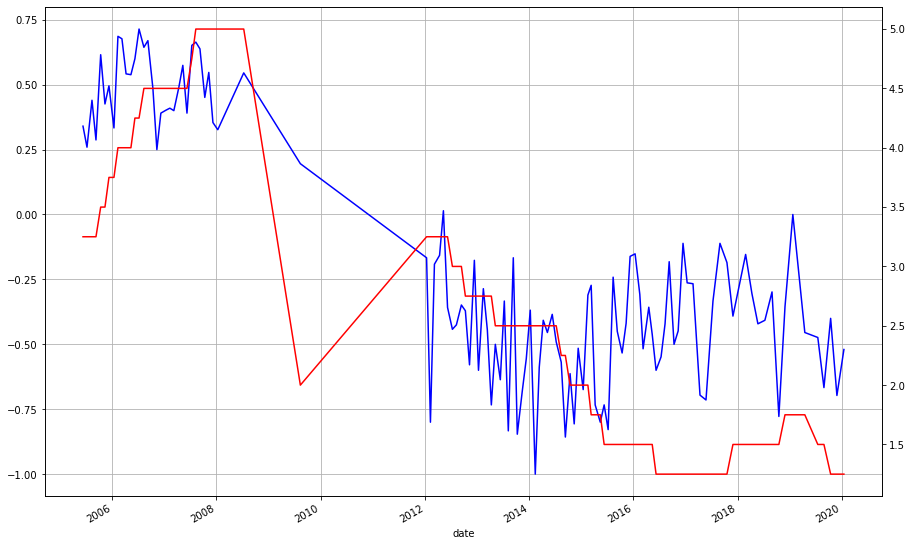

In [96]:
plt.figure(figsize=(15,10))

ax1 = tone_and_policy_rate_df.doc_tone.plot(color='blue', grid=True, label='금통위 의사록 어조')
ax2 = tone_and_policy_rate_df.base_rate.plot(color='red', grid=True, secondary_y=True, label='기준금리')

plt.show()